In [2]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Python: 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
Notebook Last Run Initiated: 2024-04-06 16:53:35.328434


## Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import tensorflow_addons as tfa
import pandas as pd
import os
from sklearn.model_selection import train_test_split

from PIL import Image
from PIL import ImageEnhance

from random import randrange

2024-04-06 16:53:45.784485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 16:53:45.885680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-06 16:53:45.885695: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-06 16:53:46.393260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.11.0


2024-04-06 16:55:03.031705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:55:03.031832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-06 16:55:03.031897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-04-06 16:55:03.031950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-04-06 16:55:03.032002: W tensorf

In [6]:
def get_filepaths(directory):
    
    file_paths = []  # List which will store all of the full filepaths.
    file_image = []  # Image filename
   
    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
                       
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.       
            file_image.append(filename.split('.')[0])

    return file_paths, file_image 

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
        
    def __init__(self, df_X, arr_Y, batch_size=32,shuffle=False,image_size=128,mode='train'):
        self.batch_size = batch_size
        self.df_X = df_X
        self.arr_Y = arr_Y
        self.indices = self.df_X.index.tolist()
        self.shuffle = shuffle
        self.image_size = image_size
        self.mode = mode
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y
    
    def n(self):
        return len(self.indices)
    
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
               
        for i, id in enumerate(batch):
                       
            # Data
            file = self.df_X.iloc[self.indices[id],0]
            img = load_img(file,color_mode='rgb', target_size=(self.image_size,self.image_size),interpolation='nearest')
            img = img_to_array(img).astype(np.float32)

            if self.mode == 'train':
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_flip_up_down(img)
                #img = tf.keras.layers.RandomRotation(factor=(-0.2, 0.2))(img)
            
            X.append(img)
            y.append(self.arr_Y[self.indices[id]])
            
        return np.array(X), np.array(y).reshape(self.batch_size,1)

## Prepare the data

In [21]:
data = pd.read_csv('train.csv')

In [22]:
#data = data.loc[data.group != 'images03']

In [23]:
#data = data.loc[data.bolts <= 15]
#data = data.loc[data.bolts > 0]

In [24]:
data.target.sum()

189

In [25]:
data.shape

(702, 4)

In [26]:
input_shape = (128, 128, 3)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, data.target.values, test_size=0.20, random_state=1)

In [28]:
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

## Configure the hyperparameters

In [29]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 500
image_size = 128  # We'll resize input images to this size
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
num_heads = 20# 16
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 24
mlp_head_units = [2048, 1024, 512]  # Size of the dense layers of the final classifier


## Implement multilayer perceptron (MLP)

In [30]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [31]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [32]:
X_train

,file_path,bolts,target,group
0,images02/s-l400.jpg,7,1,images02
1,images00/istockphoto-1379311021-612x612.jpg,1,0,images00
2,images00/8167ioghFqL._SY355_.jpg,3,0,images00
3,images03/bolts243.png,1,0,images03
4,images02/GoldTiBoltStanding_large.webp,4,0,images02
...,...,...,...,...
556,images00/istockphoto-1455150816-612x612.jpg,3,0,images00
557,images04/612yDZb-cyL._AC_SL1000_.jpg,10,1,images04
558,images00/istockphoto-1169314508-612x612.jpg,9,1,images00
559,images00/titanium-nut-bolt-1000x1000.webp,4,0,images00


2024-04-06 17:02:49.450233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Image size: 128 X 128
Patch size: 32 X 32
Patches per image: 16
Elements per patch: 3072


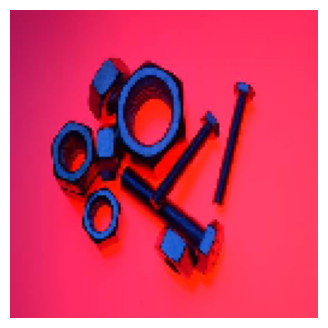

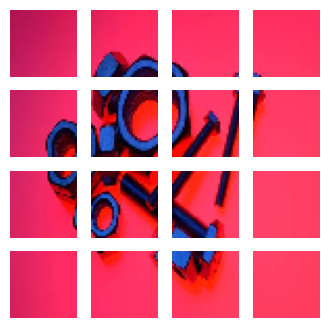

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

image = img_to_array(load_img(X_train.loc[np.random.choice(range(X_train.shape[0])),'file_path'],
                     color_mode='rgb', 
                     target_size=(image_size,image_size),
                     interpolation='nearest'))

plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [34]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [35]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    normalization = layers.Normalization(mean=136.78040649936997,variance=107.97868633912864**2)(inputs)
    
    # Create patches.
    patches = Patches(patch_size)(normalization)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # calculate outputs.
    output = layers.Dense(1,activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)
    return model


## Compile, train, and evaluate the model

In [36]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=tf.keras.metrics.AUC(name='auc'))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=2, patience=30, restore_best_weights=True)
    
    checkpoint_filepath = "tmp/checkpoint_ViT.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_auc",
        save_best_only=True,
        save_weights_only=True,
        mode='max'
    )

    train_generator = DataGenerator(df_X=X_train, arr_Y=y_train, batch_size=batch_size, shuffle=True,mode='trainx')
    test_generator = DataGenerator(df_X=X_test, arr_Y=y_test, batch_size=batch_size,mode='test')
    
    STEP_SIZE_TRAIN = train_generator.n()//train_generator.batch_size
    STEP_SIZE_VALID = test_generator.n()//test_generator.batch_size
    
    history = model.fit(x=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_generator,
                        validation_steps=STEP_SIZE_VALID, 
                        batch_size=batch_size,
                        epochs=num_epochs,
                        callbacks=[checkpoint_callback,early_stopping])

    model.load_weights(checkpoint_filepath)
    loss = model.evaluate(x=test_generator,steps=STEP_SIZE_VALID)
    print(f"loss : {loss}")

    return history

In [37]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/500
17/17 [==============================] - 185s 10s/step - loss: 2.2394 - auc: 0.5424 - val_loss: 0.7467 - val_auc: 0.7333
Epoch 2/500
17/17 [==============================] - 60s 4s/step - loss: 2.2170 - auc: 0.5885 - val_loss: 0.8679 - val_auc: 0.7249
Epoch 3/500
17/17 [==============================] - 59s 3s/step - loss: 1.4865 - auc: 0.5831 - val_loss: 0.5550 - val_auc: 0.7140
Epoch 4/500
17/17 [==============================] - 57s 3s/step - loss: 0.8534 - auc: 0.6752 - val_loss: 0.6100 - val_auc: 0.6887
Epoch 5/500
17/17 [==============================] - 58s 3s/step - loss: 1.0276 - auc: 0.5637 - val_loss: 0.5944 - val_auc: 0.6849
Epoch 6/500
17/17 [==============================] - 56s 3s/step - loss: 0.7610 - auc: 0.6345 - val_loss: 0.5416 - val_auc: 0.7288
Epoch 7/500
17/17 [==============================] - 60s 4s/step - loss: 0.7525 - auc: 0.6397 - val_loss: 0.5444 - val_auc: 0.7480
Epoch 8/500
17/17 [==============================] - 58s 3s/step - loss: 0.7200 -

In [38]:
test_generator = DataGenerator(df_X=X_test, arr_Y=y_test, batch_size=1,mode='test')
STEP_SIZE_VALID = test_generator.n()

predict_result = vit_classifier.predict(test_generator,steps=STEP_SIZE_VALID)
#prediction = 10 ** predict_result
prediction = predict_result

141/141 [==============================] - 18s 104ms/step


In [39]:
results = pd.DataFrame()
results = X_test
results['prediction'] = prediction

In [40]:
results

,file_path,bolts,target,group,prediction
0,images02/coach-bolts-plus-nuts-carriage-bolts-...,4,0,images02,0.528727
1,images03/bolts184.png,1,0,images03,0.000007
2,images01/s-l1600.jpg,2,0,images01,0.507461
3,images00/main-qimg-a028dc83c41297927c415bad661...,11,1,images00,0.412897
4,images00/istockphoto-97121349-612x612.jpg,1,0,images00,0.497156
...,...,...,...,...,...
136,images03/bolts197.png,1,0,images03,0.000002
137,images00/istockphoto-1438665802-612x612.jpg,6,1,images00,0.000517
138,images00/istockphoto-1211333306-612x612.jpg,1,0,images00,0.000043
139,images01/128-1287219_png-bolts-nuts-bolts-and-...,2,0,images01,0.489001


In [26]:
results.to_csv('results_classification.csv',index=False)